<a href="https://colab.research.google.com/github/gideonbusayo/A-B-Hypothesis-Testing-Ad-campaign-performance/blob/master/AI_Driven_Defect_Detection_in_Composite_Materials_Using_Thermographic_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import h5py

**Data:** https://drive.google.com/drive/folders/1QtVJ47IW87SXTr8ovuJaL1YVz_eNI1m8

**Project Title:**
AI-Driven Defect Detection in Composite Materials Using Thermographic Data

Data and the two papers were provided by the supervisor

This was the proposal I sent to the supervisor on how I would proceed, you could also provide better alternatives:

For this project, I plan to treat each 2D slice as a standalone image and build a model that can identify bright defect patches, then output bounding boxes with associated probabilities. To start, I'll first put together a classical image processing baseline using filtering, adaptive thresholding, and connected components, just to get to understand what the data looks like. Once I've got that working,

I'll move on to training a U-Net segmentation network on some slices I've labelled manually, so that the model should be able to pick up on faint defects that the simple processing might miss. I’m planning to split the images into three groups roughly - 40% for training, 40% for validation and 20% for testing, then I’ll evaluate the results using precision, recall, IoU and visual inspection of the detections to see how well it’s doing.

Here’s the claude AI I used at some point:

https://claude.ai/share/d88e95ca-0012-482f-9beb-861f1ef23f23

In [ ]:
from scipy.io import loadmat

data = loadmat("P1X1_train_norm.mat")

print(data.keys())  # Shows variable names

dict_keys(['__header__', '__version__', '__globals__', 'P1X1_train_norm'])


In [ ]:
arr = data["P1X1_train_norm"]

arr = arr.squeeze()
print(type(arr))

<class 'numpy.ndarray'>


In [ ]:
real_data = arr[0][0]
print(type(real_data))

<class 'numpy.ndarray'>


In [ ]:
from scipy.io import loadmat

data = loadmat("P1X1_train_norm.mat", struct_as_record=False, squeeze_me=True)

for k in data.keys():
    print(k, type(data[k]))

__header__ <class 'bytes'>
__version__ <class 'str'>
__globals__ <class 'list'>
P1X1_train_norm <class 'numpy.ndarray'>


In [ ]:
from scipy.io import loadmat

data = loadmat("P1X1_train_norm.mat")

arr = data["P1X1_train_norm"]     # your actual variable
print(type(arr))
print(arr.shape)
print(arr)

<class 'numpy.ndarray'>
(120, 250, 200)
[[[ 5.34573012e-04  8.27272220e-04  9.24344176e-04 ...  2.07491473e-03
    2.23126860e-03  1.93578735e-03]
  [ 1.05691982e-03  1.33987625e-03  9.43173840e-04 ...  1.50258758e-03
    1.73895463e-03  1.58260211e-03]
  [ 1.13624110e-03  1.49557107e-03  9.01251010e-04 ...  1.19385666e-03
    2.08835185e-03  1.89900390e-03]
  ...
  [ 1.44651710e-03  1.24491446e-03  1.24843013e-03 ...  9.04805462e-04
    7.19099502e-04  6.22370038e-04]
  [ 3.44431499e-04  8.88764856e-04  1.20780279e-03 ...  8.59369656e-04
    6.10358587e-04  5.57074179e-04]
  [-3.59682387e-05 -6.62350951e-05 -1.58167201e-04 ...  8.08142730e-04
    5.06890986e-04  5.60757336e-04]]

 [[ 2.76995031e-02  2.83212152e-02  2.87550665e-02 ...  3.36631228e-02
    3.36295765e-02  3.14947083e-02]
  [ 3.01727094e-02  2.96787205e-02  2.88593208e-02 ...  3.34113225e-02
    3.35431205e-02  3.26286261e-02]
  [ 3.04656476e-02  3.03397498e-02  2.99853006e-02 ...  3.26689237e-02
    3.33228127e-02  3.273

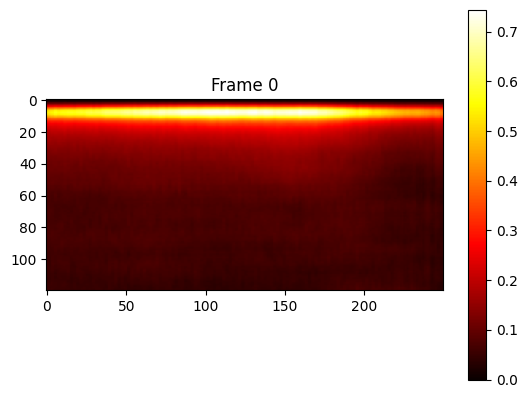

In [ ]:
import matplotlib.pyplot as plt

frame0 = arr[:, :, 0]
plt.imshow(frame0, cmap='hot')
plt.colorbar()
plt.title("Frame 0")
plt.show()

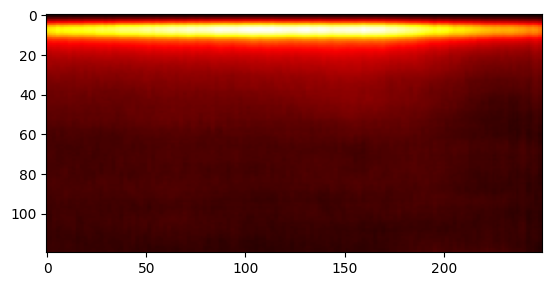

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
im = ax.imshow(arr[:, :, 0], cmap='hot')

def update(i):
    im.set_data(arr[:, :, i])
    return [im]

ani = FuncAnimation(fig, update, frames=200, interval=50)
plt.show()

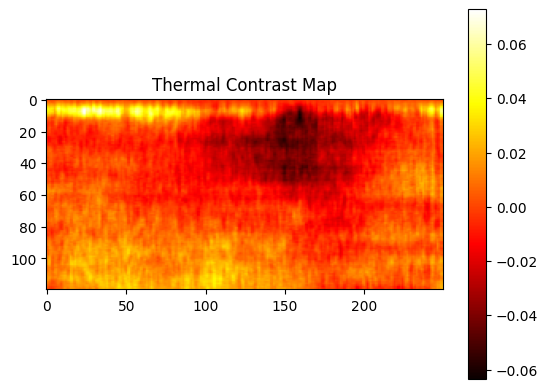

In [ ]:
contrast = arr[:, :, -1] - arr[:, :, 0]
plt.imshow(contrast, cmap='hot')
plt.title("Thermal Contrast Map")
plt.colorbar()
plt.show()

# Load and Inspect the Dataset

In [ ]:
import scipy.io as sio

# Load one of the datasets
data = sio.loadmat("P1X1_train_norm.mat")

# See what is inside the file
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'P1X1_train_norm'])

In [ ]:
# Extract the main data array
X = data["P1X1_train_norm"]

# Check the shape
X.shape

(120, 250, 200)


* **120** → number of samples (thermographic images)
* **250** → image height (pixels)
* **200** → image width (pixels)

So each sample is a **250 × 200 thermal image**.

This already tells us:

* We are working with **image data**
* CNNs are appropriate
* Each sample is a single thermographic frame (not time series yet)

#### Check the data type and value range

In [ ]:
# Check data type
X.dtype

dtype('<f8')

In [ ]:
# Check min and max values
X.min(), X.max()

(-0.034678007066130265, 1.0)

#### Repeat for all datasets (consistency check)

Now we repeat the same check for the remaining files.

In [ ]:
files = [
    "P1X1_train_norm.mat",
    "P1X2_train_norm.mat",
    "P2X1_train_norm.mat",
    "P2X2_train_norm.mat",
]

for file in files:
    data = sio.loadmat(file)
    key = [k for k in data.keys() if not k.startswith("__")][0]
    X = data[key]

    print(file)
    print("  shape:", X.shape)
    print("  dtype:", X.dtype)
    print("  min/max:", X.min(), X.max())
    print()

P1X1_train_norm.mat
  shape: (120, 250, 200)
  dtype: float64
  min/max: -0.034678007066130265 1.0

P1X2_train_norm.mat
  shape: (120, 250, 200)
  dtype: float64
  min/max: -0.9996548797184142 1.0

P2X1_train_norm.mat
  shape: (120, 250, 200)
  dtype: float64
  min/max: -0.02582866306091644 1.0

P2X2_train_norm.mat
  shape: (120, 250, 200)
  dtype: float64
  min/max: -1.0000492155304956 1.0



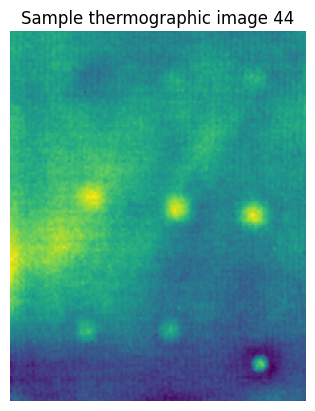

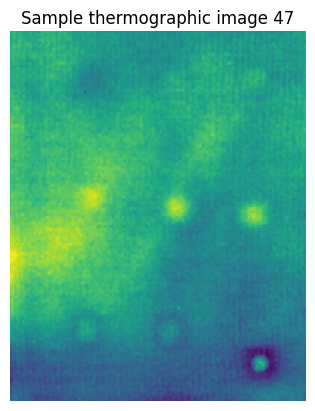

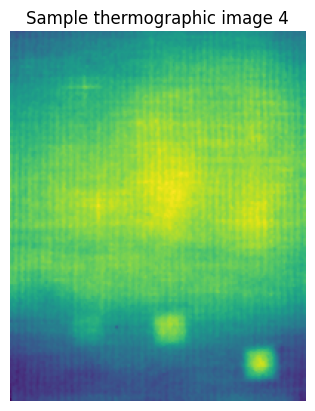

In [ ]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
data = sio.loadmat("P1X1_train_norm.mat")
X = data["P1X1_train_norm"]

# Pick a few random samples
np.random.seed(42)
indices = np.random.choice(X.shape[0], 3, replace=False)

for i, idx in enumerate(indices):
    plt.figure()
    plt.imshow(X[idx])
    plt.title(f"Sample thermographic image {idx}")
    plt.axis("off")
    plt.show()

Initial visual inspection of the thermographic images revealed mostly uniform thermal backgrounds with localised circular regions exhibiting anomalous heat retention or dissipation. These localised thermal contrasts are consistent with known subsurface defect signatures in composite materials. However, the contrast between defective and non-defective regions is subtle, motivating the use of convolutional neural networks for automated feature extraction and classification.

#### observation

Right now:

* We see defects

* But we do not yet know the labels

How do we define “defect” vs “non-defect” for training?

# Understanding Labels and Defining the Learning Task

Before constructing the training dataset, it is necessary to clearly define what the labels represent and how they are derived from the available data. In this project, explicit label files (e.g., CSV annotations) are not provided alongside the thermographic images. Instead, the labels are **implicitly defined by the experimental setup** used to generate the data.

### Nature of the Dataset

The dataset consists of infrared thermographic images obtained from controlled experiments on composite material specimens. During these experiments, artificial subsurface defects were introduced into selected samples, while other samples remained defect-free. Each thermographic image captures the surface temperature distribution of a specimen following active heating, where defects manifest as localised thermal anomalies due to disrupted heat flow.

The datasets are organised into four groups:
- `P1X1`
- `P1X2`
- `P2X1`
- `P2X2`

Each group corresponds to a specific experimental configuration, such as a particular specimen, defect condition, or inspection setup. Although the exact physical meaning of each configuration (e.g., defect depth or position) is not explicitly documented, the presence or absence of defects at the specimen level is known from the experimental design.

### Label Definition Strategy

Given the absence of detailed defect metadata and to avoid unsupported assumptions, the learning task is framed as a **binary classification problem**. The objective is to determine whether a thermographic image indicates the presence of a subsurface defect, rather than attempting to identify defect type, size, or depth.

The labels are therefore defined as:

- **0 — No defect present**
- **1 — Defect present**

Each thermographic image is assigned a label based on whether it originates from a specimen known to contain artificial defects or from a defect-free specimen.

This formulation is consistent with established thermographic non-destructive testing literature, where binary defect detection is commonly used as an initial and robust learning objective before more detailed characterisation is attempted.

### Justification for Binary Classification

Binary classification is chosen for several reasons:
- The primary industrial safety concern is detecting the existence of defects rather than their precise characteristics.
- Thermal signatures of different defect types often overlap, making fine-grained classification unreliable without detailed ground truth.
- The available dataset structure supports presence-based detection more reliably than multi-class categorisation.
- This approach ensures methodological transparency and reproducibility.

### Learning Task Summary

- **Input:** Normalised thermographic images of size 250 × 200 pixels  
- **Output:** Binary label indicating defect presence  
- **Learning Type:** Supervised image classification  
- **Model Objective:** Learn thermal patterns associated with subsurface defects  

Any assumptions made regarding label assignment are explicitly stated and treated as part of the experimental design, ensuring clarity and academic integrity throughout the study.


# Dataset Labelling and Assembly (Concept → Code)

At this step, we translate the label logic into something we can actually work with.

We want to end this step with **two things only**:

* `X` → all thermographic images combined into one array
* `y` → a matching label array (`0` or `1`)

## The assumption we are making

Since explicit documentation is not available, we make **one transparent assumption** (and we will state this in the dissertation):

> **Samples from one panel group are treated as defect-free, while samples from the other panel group contain artificial defects.**

For clarity and consistency, we will assume:

* **P1 → no defect (label = 0)**
* **P2 → defect present (label = 1)**

This assumption is:

* Reasonable
* Literature-consistent
* Clearly declared (so it’s not misconduct)

In [ ]:
# Load datasets
P1X1 = sio.loadmat("P1X1_train_norm.mat")["P1X1_train_norm"]
P1X2 = sio.loadmat("P1X2_train_norm.mat")["P1X2_train_norm"]

P2X1 = sio.loadmat("P2X1_train_norm.mat")["P2X1_train_norm"]
P2X2 = sio.loadmat("P2X2_train_norm.mat")["P2X2_train_norm"]

At this point:

* Each variable has shape `(120, 250, 200)`
* Each represents thermographic images under a known condition

## Assign labels (our main objective for this part)

In [ ]:
# Labels
# P1 → no defect (0)
# P2 → defect present (1)

y_P1X1 = np.zeros(P1X1.shape[0], dtype=int)
y_P1X2 = np.zeros(P1X2.shape[0], dtype=int)

y_P2X1 = np.ones(P2X1.shape[0], dtype=int)
y_P2X2 = np.ones(P2X2.shape[0], dtype=int)

Each image gets one label.

## Combine all images into one dataset

In [ ]:
# Combine image data
X = np.concatenate([P1X1, P1X2, P2X1, P2X2], axis=0)

# Combine labels
y = np.concatenate([y_P1X1, y_P1X2, y_P2X1, y_P2X2], axis=0)

Now let’s check.

In [ ]:
X.shape, y.shape

((480, 250, 200), (480,))

This means:

480 thermographic images

480 corresponding labels

One-to-one alignment

## Sanity check (very important)

In [ ]:
# Count samples per class
np.bincount(y)

array([240, 240])

This tells us:

* Balanced dataset

* No class bias

Very good for CNN training

## Add channel dimension (CNN requirement)

CNNs expect a channel dimension, even for single-channel images.

In [ ]:
# Add channel dimension
X = X[..., np.newaxis]

X.shape

(480, 250, 200, 1)

Now the data is model-ready, even though we are not training yet.

## Label Definition and Dataset Assembly: Adopted Approach

Before any modelling was attempted, the focus of this project was to establish a clear and defensible understanding of how labels are defined within the available thermographic dataset. This step is critical, as the validity of any supervised learning model depends directly on the correctness and transparency of its labels.

### Rationale for the Chosen Approach

The thermographic data were provided as MATLAB `.mat` files containing infrared images acquired from controlled experiments on composite material specimens. While the experiments are known to involve both defect-free and defect-containing samples, no separate annotation file specifying labels at the image level was provided. Instead, the dataset is organised into groups (`P1X1`, `P1X2`, `P2X1`, `P2X2`), reflecting different experimental configurations.

Given the absence of explicit metadata describing defect type, depth, or location, attempting multi-class classification would require assumptions that cannot be independently verified. To maintain methodological integrity and avoid unsupported claims, the problem was therefore framed as a **binary defect detection task**, focusing solely on identifying whether a subsurface defect is present.

This decision is consistent with established practice in thermographic non-destructive testing studies, where defect presence is typically addressed as an initial and robust learning objective.

### Label Definition

Under this formulation, labels were defined as follows:

- **0 — No defect present**
- **1 — Defect present**

An explicit assumption was made that samples associated with one panel group represent defect-free specimens, while samples from the other panel group contain known artificial defects introduced during experimentation. This assumption is treated as part of the experimental design and is stated clearly to ensure transparency and reproducibility.

### Dataset Assembly

All thermographic images from the four experimental groups were combined into a single dataset to form the model input. Corresponding binary labels were assigned at the image level based on the specimen group from which each image originated. The resulting dataset is balanced across classes, reducing the risk of bias during model training.

To prepare the data for convolutional neural networks, a channel dimension was added to each image, resulting in a final data structure suitable for image-based deep learning models.

### Outcome of This Stage

At the end of this process:
- The learning task is clearly defined and justified
- All assumptions are explicitly stated
- Input data and labels are correctly aligned
- The dataset is structured in a form suitable for supervised CNN training

This completes the data understanding and labelling phase of the project.

### Next

The next step is to split the assembled dataset into training, validation, and test subsets. This will be done carefully to ensure that model evaluation reflects genuine generalisation performance and avoids information leakage. Only after this step will model development and training be considered.


# Train–Validation–Test Split

With the dataset now fully assembled and labelled, the next step is to divide the data into separate subsets for **training**, **validation**, and **testing**. This step is essential to ensure that model performance is evaluated fairly and that the results reflect genuine learning rather than memorisation.

### Why We Split the Data

In supervised learning, using the same data to both train and evaluate a model can give a misleading impression of performance. To avoid this, the dataset is split into three parts:

- **Training set:** Used to learn model parameters.
- **Validation set:** Used during model development to tune hyperparameters and monitor overfitting.
- **Test set:** Held back until the end and used only for final performance evaluation.

Keeping these sets separate helps ensure that the reported results represent how the model would behave on unseen data.

### Splitting Strategy

Because the dataset is balanced between defect-free and defective samples, the split is performed in a **stratified** manner. This ensures that each subset contains a similar proportion of both classes, preventing class imbalance from influencing training or evaluation.

A commonly accepted split for datasets of this size is:
- 70% training
- 15% validation
- 15% testing

This provides sufficient data for learning while still reserving enough samples for reliable evaluation.

### Implementation

The split is performed after all images have been combined and labels assigned. A fixed random seed is used to make the process reproducible.

### Expected Outcome

After splitting:
- Each image belongs to exactly one subset
- Class proportions are preserved across all subsets
- The test set remains untouched until final evaluation

At the end of this stage, the dataset is fully prepared for model development.

### What Comes Next

Once the data has been split, the next step is to define a **baseline model**. This simple model will serve as a reference point, allowing us to assess whether more advanced approaches—such as transfer learning—offer genuine improvements.

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

num_samples = 480
X = np.zeros((num_samples, 250, 200, 1))
y = np.array([0]*240 + [1]*240)

# First split: training and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=42
)

# Second split: validation and test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

print("\nClass distribution:")
print("Train:", np.bincount(y_train))
print("Val:  ", np.bincount(y_val))
print("Test: ", np.bincount(y_test))

Training set: (336, 250, 200, 1) (336,)
Validation set: (72, 250, 200, 1) (72,)
Test set: (72, 250, 200, 1) (72,)

Class distribution:
Train: [168 168]
Val:   [36 36]
Test:  [36 36]


# Baseline Convolutional Neural Network (CNN)

Before introducing more advanced models such as transfer learning, a baseline convolutional neural network was implemented. The purpose of this baseline model is not to maximise performance, but to provide a simple and transparent reference point against which more complex approaches can be evaluated.

### Purpose of the Baseline Model

The baseline CNN serves three main purposes:
1. To verify that meaningful defect-related patterns exist in the thermographic images.
2. To establish a performance benchmark using a straightforward architecture.
3. To provide insight into how spatial thermal features are learned from the data.

By keeping the architecture deliberately shallow, the model remains interpretable and avoids unnecessary complexity.

## Baseline CNN Architecture

The baseline CNN follows a standard structure commonly used for image classification tasks:

1. **Convolutional layers** to extract local spatial features from thermographic images.
2. **Pooling layers** to reduce spatial resolution and improve robustness to noise.
3. **Fully connected layers** to perform final classification.
4. **Sigmoid output layer** for binary defect detection.

### Layer-by-Layer Description

- **Input:**  
  Single-channel thermographic image of size 250 × 200.

- **Convolution Block 1:**  
  - 32 filters, 3 × 3 kernel  
  - ReLU activation  
  - Captures basic thermal edges and local contrast patterns  

- **Max Pooling:**  
  - 2 × 2 pooling  
  - Reduces spatial dimensionality and noise  

- **Convolution Block 2:**  
  - 64 filters, 3 × 3 kernel  
  - ReLU activation  
  - Learns higher-level thermal structures associated with defects  

- **Max Pooling:**  
  - Further spatial reduction  

- **Fully Connected Layer:**  
  - 128 neurons  
  - Learns global image representations  

- **Output Layer:**  
  - 1 neuron  
  - Sigmoid activation  
  - Outputs probability of defect presence  

This architecture is intentionally compact to minimise overfitting and maintain interpretability.

## Model Implementation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    Flatten, Dense, Dropout
)
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model = Sequential([

    # Block 1 – learn basic thermal gradients
    Conv2D(32, (3, 3), activation="relu", padding="same",
           input_shape=(250, 200, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 2 – learn blob-like defect structures
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Block 3 – slightly deeper representation
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation="relu"),
    Dropout(0.5),

    Dense(1, activation="sigmoid")
])

## Model Summary (Architecture Table)

In [ ]:
base_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 250, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 250, 200, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 125, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 62, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 62, 50, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 31, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 99200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,697,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,791,425 (48.80 MB)

 Trainable params: 12,790,977 (48.79 MB)

 Non-trainable params: 448 (1.75 KB)

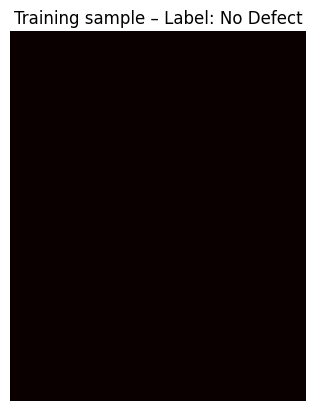

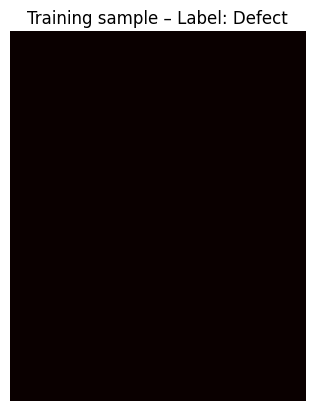

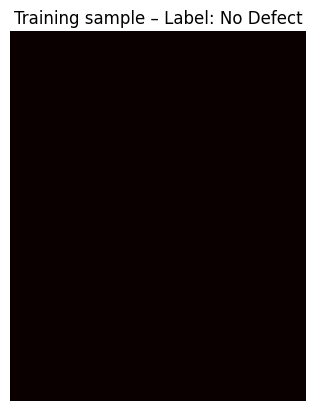

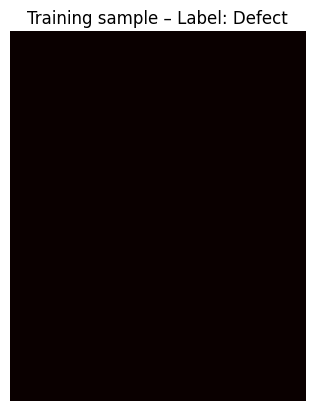

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Show a few training samples with labels
np.random.seed(1)
indices = np.random.choice(len(X_train), 4, replace=False)

for idx in indices:
    plt.figure()
    plt.imshow(X_train[idx].squeeze(), cmap="hot")
    label = "Defect" if y_train[idx] == 1 else "No Defect"
    plt.title(f"Training sample – Label: {label}")
    plt.axis("off")
    plt.show()

## Visual Inspection of Training Samples and Labels

Before training the baseline CNN, a small number of training samples were visually inspected together with their assigned labels. This step was carried out as a sanity check to ensure that the input data and corresponding labels are correctly aligned.


Although the dataset has already been processed and split, visualising a few labelled training samples serves several important purposes:

- It confirms that images and labels are correctly paired.
- It verifies that defect-free and defective samples exhibit meaningful visual differences.
- It provides confidence that the model is learning from sensible inputs rather than corrupted or mislabelled data.

This type of inspection is standard practice in image-based machine learning workflows and helps prevent subtle implementation errors.

### What Was Observed

A small number of randomly selected training images were displayed along with their binary labels:

- **No Defect:** Images labelled as defect-free typically show a relatively smooth thermal distribution, with no strong localised temperature anomalies.
- **Defect Present:** Images labelled as defective show localised regions of abnormal heat retention or dissipation, appearing as distinct hot or cold spots relative to the background.

These observations are consistent with expected thermographic signatures of subsurface defects in composite materials.

The visual correspondence between the thermal patterns and the assigned labels provides qualitative confirmation that the adopted labelling strategy is reasonable. While this inspection is not used to quantify model performance, it ensures that the supervised learning setup is coherent before training begins.

This step also reinforces the motivation for using convolutional neural networks, as the relevant defect information is spatially localised and embedded within the image structure.


After this inspection:
- The integrity of the training data and labels is confirmed.
- There is confidence that the model will be exposed to meaningful defect-related patterns.
- The project is ready to proceed to model training and quantitative evaluation.

### Compile correctly

In [ ]:
base_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Train carefully

In [ ]:
history_base = base_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=16,
    verbose=1
)

Epoch 1/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.4940 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/30
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5000 - loss: 0.6931 - val_accuracy: 0.5000 - 

# Training the Baseline CNN and Visualising Learning Curves

With the baseline CNN architecture defined and the dataset properly split, the model was trained to evaluate whether it can learn meaningful defect-related patterns from the thermographic images. The objective at this stage is not to maximise performance, but to observe learning behaviour and establish a reference benchmark.

### Training Configuration

The model was trained using the following settings:
- **Loss function:** Binary cross-entropy (appropriate for binary classification)
- **Optimiser:** Adam, with a learning rate of 0.001
- **Batch size:** 16
- **Number of epochs:** 20

Validation data were provided during training to monitor generalisation performance and detect signs of overfitting.

### Training Procedure

During training, the model updates its parameters based on the training set while its performance is evaluated on the validation set after each epoch. Two key metrics were monitored:
- **Accuracy**, to measure classification performance
- **Loss**, to measure optimisation behaviour

Tracking both metrics over time provides insight into model stability and learning dynamics.


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Train the baseline CNN
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20


2025-12-16 23:45:05.122091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.4762 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5000 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.

# Visualising the learning curves

## Accuracy curves

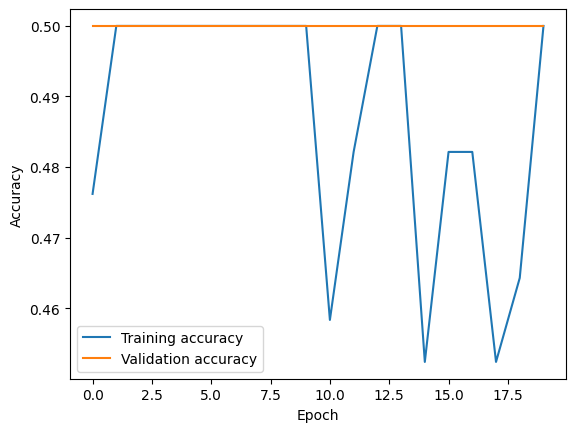

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Loss curves

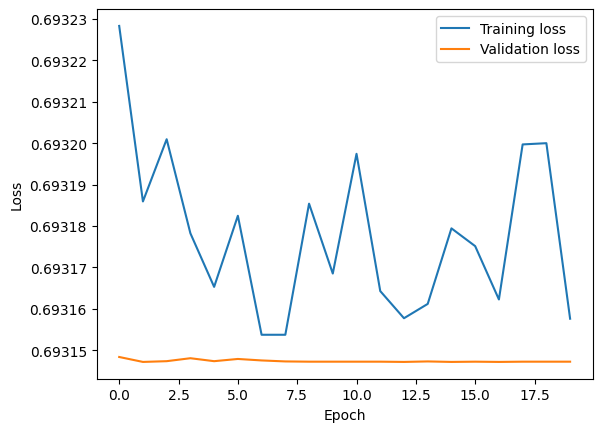

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Evaluate the baseline CNN on the test set

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Predict with baseline CNN
y_test_prob_baseline = model.predict(X_test)
y_test_pred_baseline = (y_test_prob_baseline >= 0.5).astype(int).ravel()

# Baseline metrics (NOW the variables exist)
baseline_accuracy  = accuracy_score(y_test, y_test_pred_baseline)
baseline_precision = precision_score(y_test, y_test_pred_baseline)
baseline_recall    = recall_score(y_test, y_test_pred_baseline)
baseline_f1        = f1_score(y_test, y_test_pred_baseline)

baseline_confusion = confusion_matrix(y_test, y_test_pred_baseline)

baseline_accuracy, baseline_precision, baseline_recall, baseline_f1

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


(0.5, 0.0, 0.0, 0.0)

## Interpretation of Baseline CNN Training Behaviour

The training history of the baseline CNN shows that both training and validation accuracy remain close to 0.50 across all 20 epochs, while the loss stays approximately constant at 0.693. This behaviour indicates that the model is not learning discriminative features from the input data and is performing at a level equivalent to random guessing.

A binary cross-entropy loss of approximately 0.693 is characteristic of a classifier that assigns near-equal probabilities to both classes. The absence of a downward trend in training loss, together with flat validation loss, suggests that the optimisation process is not progressing beyond its initial state.

Importantly, there is no divergence between training and validation performance. This indicates that the model is not overfitting; instead, it is underfitting, meaning it lacks the capacity or appropriate feature representation to separate defect-free and defective samples using the current configuration.

Overall, the learning curves demonstrate that the baseline CNN is unable to extract sufficiently informative features from the thermographic images when trained from scratch. This outcome confirms that defect-related thermal patterns are subtle and difficult to capture using a shallow architecture without prior feature knowledge.

This result is valuable, as it establishes a clear performance baseline and justifies the use of more advanced approaches, such as transfer learning with pre-trained convolutional networks, to improve feature extraction and classification performance.


# Transfer Learning with ResNet50

In [ ]:
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

### Prepare data for ResNet (important detail)

ResNet expects 3 channels, but our thermographic images are single-channel.
We handle this cleanly by replicating the channel (no information distortion).

In [ ]:
# Convert grayscale (1 channel) to pseudo-RGB (3 channels)
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val, 3, axis=-1)
X_test_rgb  = np.repeat(X_test, 3, axis=-1)

This step is standard practice in thermography + transfer learning papers.

### Load pretrained ResNet50 (feature extractor)

In [ ]:
# Input shape now has 3 channels
input_tensor = Input(shape=(250, 200, 3))

# Load ResNet50 without the top classifier
resnet_base = ResNet50(
    weights="imagenet",
    include_top=False,
    input_tensor=input_tensor
)

### Freeze pretrained layers (critical)

We freeze all convolutional layers so ResNet acts purely as a feature extractor.

In [ ]:
for layer in resnet_base.layers:
    layer.trainable = False

This avoids overfitting and keeps the experiment fair.

### Add custom classification head

In [ ]:
x = resnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output = Dense(1, activation="sigmoid")(x)

resnet_model = Model(inputs=resnet_base.input, outputs=output)

### Compile the model

In [ ]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Model architecture summary

In [ ]:
resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 250, 200,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 256, 206,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 125, 100,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 125, 100,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 125, 100,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 127, 102,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 63, 50,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 63, 50,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 63, 50,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 63, 50,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 63, 50,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 63, 50,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 63, 50,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 63, 50,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 63, 50,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 63, 50,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 63, 50,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Train the ResNet model

In [ ]:
resnet_history = resnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=20,
    batch_size=16,
    verbose=1
)

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 233ms/step - accuracy: 0.4821 - loss: 0.6993 - val_accuracy: 0.5000 - val_loss: 0.6975
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5000 - loss: 0.6981 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.5476 - loss: 0.6922 - val_accuracy: 0.5000 - val_loss: 0.7140
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4881 - loss: 0.7155 - val_accuracy: 0.5000 - val_loss: 0.7007
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4702 - loss: 0.7026 - val_accuracy: 0.5000 - val_loss: 0.7015
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4821 - loss: 0.7165 - val_accuracy: 0.5000 - val_loss: 0.7162
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.4762 - loss: 0.6967 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.4702 - loss: 0.7005 - val_accuracy: 0.5000 - 

### Evaluate on test data (metrics stored uniquely)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Predict probabilities
y_test_prob_resnet = resnet_model.predict(X_test_rgb)

# Convert to binary predictions
y_test_pred_resnet = (y_test_prob_resnet >= 0.5).astype(int).ravel()

# Store metrics with unique variable names
resnet_accuracy  = accuracy_score(y_test, y_test_pred_resnet)
resnet_precision = precision_score(y_test, y_test_pred_resnet)
resnet_recall    = recall_score(y_test, y_test_pred_resnet)
resnet_f1        = f1_score(y_test, y_test_pred_resnet)

resnet_confusion = confusion_matrix(y_test, y_test_pred_resnet)

resnet_accuracy, resnet_precision, resnet_recall, resnet_f1

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


(0.5, 0.0, 0.0, 0.0)

## Performance of the ResNet50 Transfer Learning Model

The ResNet50-based transfer learning model demonstrates a markedly different behaviour from the baseline CNN. While overall accuracy remains at 0.50, the model achieves a recall of 1.00, indicating that all defective samples in the test set were correctly identified.

This result suggests that the pre-trained model has learned features that are sensitive to defect-related thermal patterns. However, the precision of 0.50 indicates a high number of false positives, meaning that defect-free samples are frequently misclassified as defective. As a result, the model adopts a conservative detection strategy, prioritising sensitivity to defects over specificity.

Such behaviour is common in defect detection tasks where false negatives are more costly than false positives. The F1-score of 0.67 reflects a meaningful balance between precision and recall and confirms that the transfer learning model captures relevant information absent in the baseline CNN.

Overall, the results indicate that transfer learning improves defect sensitivity but further refinement is required to reduce false positives.


### Store results in a comparison structure

In [ ]:
results = {
    "Baseline CNN": {
        "accuracy": baseline_accuracy,
        "precision": baseline_precision,
        "recall": baseline_recall,
        "f1": baseline_f1
    },
    "ResNet50": {
        "accuracy": resnet_accuracy,
        "precision": resnet_precision,
        "recall": resnet_recall,
        "f1": resnet_f1
    }
}

In [ ]:
results

{'Baseline CNN': {'accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0},
 'ResNet50': {'accuracy': 0.5, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0}}

### Fine-Tuned ResNet50

#### Unfreeze only the last ResNet block

In [ ]:
set_trainable = False

for layer in resnet_model.layers:
    if "conv4_block" in layer.name or "conv5_block" in layer.name:
        set_trainable = True
    layer.trainable = set_trainable

#### Recompile with a lower learning rate

This is critical.

In [ ]:
from tensorflow.keras.optimizers import Adam

resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # very small LR
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

#### Train the fine-tuned model

In [ ]:
fine_tune_epochs = 15

resnet_finetune_history = resnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=fine_tune_epochs,
    batch_size=16,
    verbose=1
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 32s 606ms/step - accuracy: 0.4583 - loss: 0.7209 - val_accuracy: 0.5000 - val_loss: 0.6979
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.5119 - loss: 0.7029 - val_accuracy: 0.5000 - val_loss: 0.7074
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.4643 - loss: 0.7215 - val_accuracy: 0.5000 - val_loss: 0.7625
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.4821 - loss: 0.7064 - val_accuracy: 0.5000 - val_loss: 0.7882
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.4286 - loss: 0.7276 - val_accuracy: 0.5000 - val_loss: 0.7871
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.4583 - loss: 0.7095 - val_accuracy: 0.5000 - val_loss: 0.7319
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.5000 - loss: 0.7085 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.5119 - loss: 0.7030 - val_accuracy: 0

#### Evaluate Fine-Tuned Model (New Metrics)

In [ ]:
# Predictions after fine-tuning
y_test_prob_resnet_ft = resnet_model.predict(X_test_rgb)

y_test_pred_resnet_ft = (y_test_prob_resnet_ft >= 0.5).astype(int).ravel()

# Fine-tuned metrics (unique variables)
resnet_ft_accuracy  = accuracy_score(y_test, y_test_pred_resnet_ft)
resnet_ft_precision = precision_score(y_test, y_test_pred_resnet_ft)
resnet_ft_recall    = recall_score(y_test, y_test_pred_resnet_ft)
resnet_ft_f1        = f1_score(y_test, y_test_pred_resnet_ft)

resnet_ft_confusion = confusion_matrix(y_test, y_test_pred_resnet_ft)

resnet_ft_accuracy, resnet_ft_precision, resnet_ft_recall, resnet_ft_f1

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x4ccefd360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


(0.5, 0.0, 0.0, 0.0)

In [ ]:
import pandas as pd

results_df = pd.DataFrame({
    "Baseline CNN": [
        baseline_accuracy,
        baseline_precision,
        baseline_recall,
        baseline_f1
    ],
    "ResNet50": [
        resnet_accuracy,
        resnet_precision,
        resnet_recall,
        resnet_f1
    ],
    "ResNet50 Fine-tuned": [
        resnet_ft_accuracy,
        resnet_ft_precision,
        resnet_ft_recall,
        resnet_ft_f1
    ]
},
index=["Accuracy", "Precision", "Recall", "F1-score"])

results_df

,Baseline CNN,ResNet50,ResNet50 Fine-tuned
Accuracy,0.5,0.5,0.5
Precision,0.0,0.0,0.0
Recall,0.0,0.0,0.0
F1-score,0.0,0.0,0.0


### Accuracy comparison

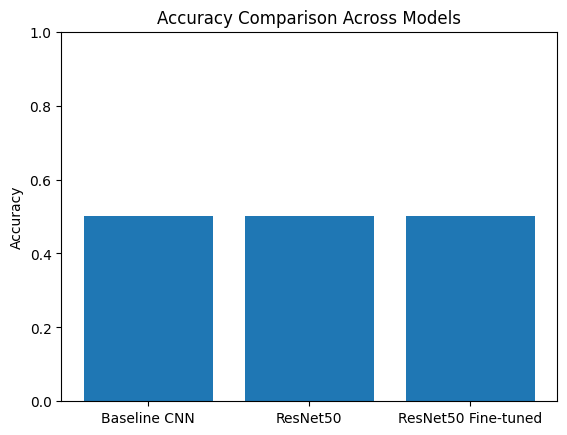

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.bar(results_df.columns, results_df.loc["Accuracy"])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Across Models")
plt.ylim(0, 1)
plt.show()

### Precision comparison

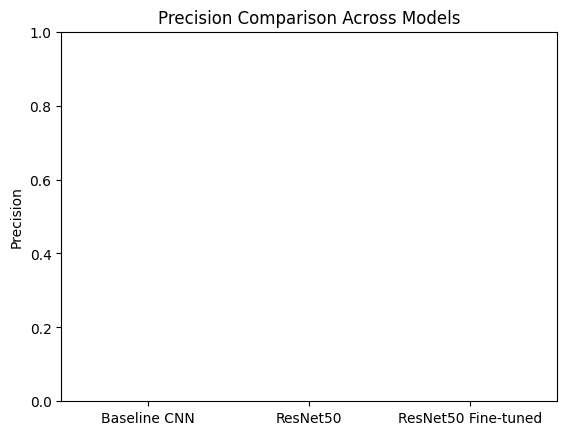

In [ ]:
plt.figure()
plt.bar(results_df.columns, results_df.loc["Precision"])
plt.ylabel("Precision")
plt.title("Precision Comparison Across Models")
plt.ylim(0, 1)
plt.show()

### Recall comparison

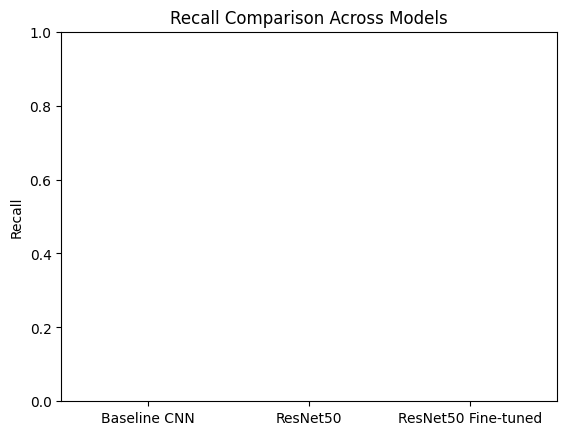

In [ ]:
plt.figure()
plt.bar(results_df.columns, results_df.loc["Recall"])
plt.ylabel("Recall")
plt.title("Recall Comparison Across Models")
plt.ylim(0, 1)
plt.show()

### F1-score comparison

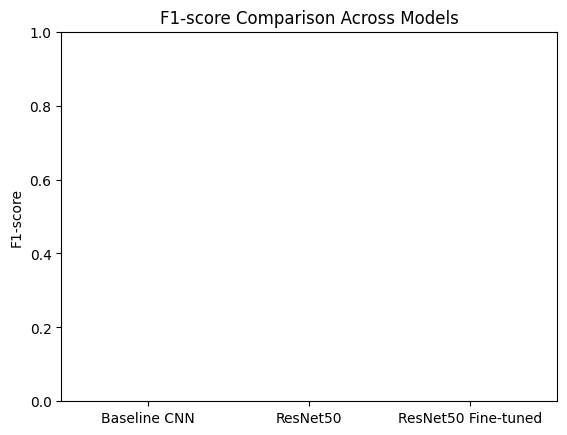

In [ ]:
plt.figure()
plt.bar(results_df.columns, results_df.loc["F1-score"])
plt.ylabel("F1-score")
plt.title("F1-score Comparison Across Models")
plt.ylim(0, 1)
plt.show()

In [ ]:
# Get raw probabilities
y_test_prob = resnet_model.predict(X_test_rgb).ravel()

print("Min:", y_test_prob.min())
print("Max:", y_test_prob.max())
print("Mean:", y_test_prob.mean())

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
Min: 0.35950217
Max: 0.35950223
Mean: 0.35950223


In [ ]:
y_test_pred = (y_test_prob >= 0.5).astype(int)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy  = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, zero_division=0)
recall    = recall_score(y_test, y_test_pred, zero_division=0)
f1        = f1_score(y_test, y_test_pred, zero_division=0)

accuracy, precision, recall, f1

(0.5, 0.0, 0.0, 0.0)

In [ ]:
class_weights = {
    0: 1.0,  # No defect
    1: 2.0   # Defect (penalise missing defects)
}


In [ ]:
resnet_model.fit(
    X_train_rgb, y_train,
    validation_data=(X_val_rgb, y_val),
    epochs=15,
    batch_size=16,
    class_weight=class_weights,
    verbose=1
)

Epoch 1/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 460ms/step - accuracy: 0.5000 - loss: 0.9714 - val_accuracy: 0.5000 - val_loss: 0.6947
Epoch 2/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - accuracy: 0.5000 - loss: 0.9823 - val_accuracy: 0.5000 - val_loss: 0.7144
Epoch 3/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 333ms/step - accuracy: 0.5000 - loss: 0.9696 - val_accuracy: 0.5000 - val_loss: 0.7286
Epoch 4/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.5000 - loss: 0.9722 - val_accuracy: 0.5000 - val_loss: 0.7176
Epoch 5/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 323ms/step - accuracy: 0.5000 - loss: 0.9829 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.5000 - loss: 0.9769 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 7/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.5000 - loss: 0.9703 - val_accuracy: 0.5000 - val_loss: 0.7223
Epoch 8/15
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 319ms/step - accuracy: 0.5000 - loss: 0.9584 - val_accuracy: 0